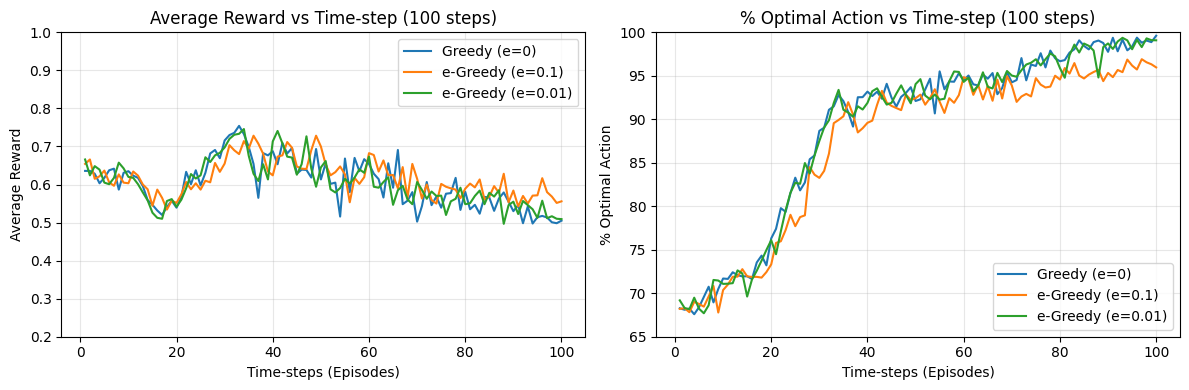

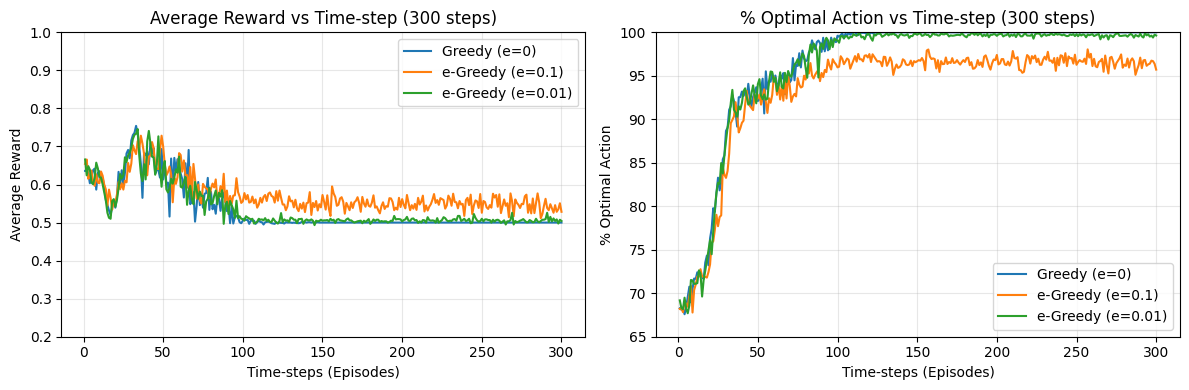

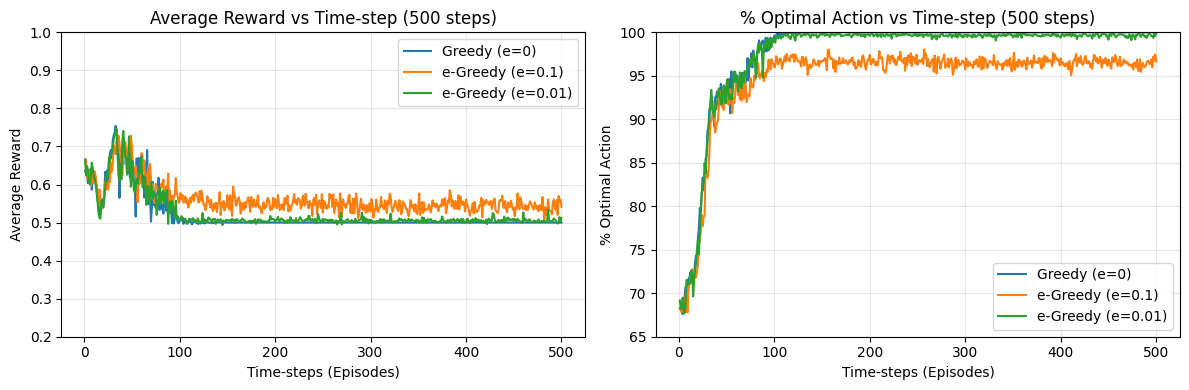

In [3]:
# Tic-Tac-Toe RL (Q-learning) + learning curves
# Produces figures for 100, 300, 500 steps:
#   - Average Reward vs Time-step (N steps)
#   - % Optimal Action vs Time-step (N steps)
#
# Curves shown (3 lines):
#   - Greedy (ε=0)
#   - ε-Greedy (ε=0.1)
#   - ε-Greedy (ε=0.01)

import random
from functools import lru_cache
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Tic-Tac-Toe Environment
# -----------------------------
EMPTY, X, O = 0, 1, 2

WIN_LINES = [
    (0, 1, 2), (3, 4, 5), (6, 7, 8),
    (0, 3, 6), (1, 4, 7), (2, 5, 8),
    (0, 4, 8), (2, 4, 6)
]

def check_winner(board):
    for a, b, c in WIN_LINES:
        if board[a] != EMPTY and board[a] == board[b] == board[c]:
            return board[a]
    return 0

def is_full(board):
    return all(v != EMPTY for v in board)

def legal_actions(board):
    return [i for i, v in enumerate(board) if v == EMPTY]

def next_player(p):
    return O if p == X else X

def make_move(board, action, player):
    b = list(board)
    b[action] = player
    return tuple(b)

# -----------------------------
# Minimax for "% optimal action"
# -----------------------------
@lru_cache(None)
def minimax_value(board, player_to_move):
    winner = check_winner(board)
    if winner == player_to_move:
        return 1
    if winner == next_player(player_to_move):
        return -1
    if is_full(board):
        return 0

    best = -2
    for a in legal_actions(board):
        nb = make_move(board, a, player_to_move)
        v = -minimax_value(nb, next_player(player_to_move))
        if v > best:
            best = v
        if best == 1:
            break
    return best

@lru_cache(None)
def minimax_best_actions(board, player_to_move):
    best = -2
    best_actions = set()
    for a in legal_actions(board):
        nb = make_move(board, a, player_to_move)
        v = -minimax_value(nb, next_player(player_to_move))
        if v > best:
            best = v
            best_actions = {a}
        elif v == best:
            best_actions.add(a)
    return best_actions

# -----------------------------
# Q-learning Agent
# -----------------------------
class QAgent:
    def __init__(self, player_id, epsilon=0.1, alpha=0.2, gamma=0.95, q_init=1.0):
        self.player = player_id
        self.epsilon = float(epsilon)
        self.alpha = float(alpha)
        self.gamma = float(gamma)
        self.q_init = float(q_init)
        self.Q = {}  # state -> np.array(9)

    def _q_row(self, s):
        # optimistic initialization helps ε=0 learn
        if s not in self.Q:
            self.Q[s] = np.ones(9, dtype=np.float32) * self.q_init
        return self.Q[s]

    def act(self, board):
        acts = legal_actions(board)
        if not acts:
            return None

        # epsilon-greedy exploration
        if random.random() < self.epsilon:
            return random.choice(acts)

        q = self._q_row(board)

        # random tie-break among best actions (prevents flat greedy line)
        best_q = max(q[a] for a in acts)
        best_actions = [a for a in acts if q[a] == best_q]
        return random.choice(best_actions)

    def update(self, s, a, r, s_next, done):
        q = self._q_row(s)
        target = r
        if not done:
            qn = self._q_row(s_next)
            acts_next = legal_actions(s_next)
            if acts_next:
                target = r + self.gamma * float(np.max(qn[acts_next]))
        q[a] += self.alpha * (target - q[a])

# -----------------------------
# One game episode (self-play)
# Reward scaled to [0,1]:
#   win=1.0, draw=0.5, loss=0.0 (from X perspective)
# -----------------------------
def play_episode(agentX, agentO):
    board = tuple([EMPTY] * 9)
    player = X

    last_sa = {X: None, O: None}

    optimal_taken = 0
    total_moves_X = 0

    while True:
        if player == X:
            a = agentX.act(board)

            # track optimal action % for X moves
            best = minimax_best_actions(board, X)
            total_moves_X += 1
            if a in best:
                optimal_taken += 1

            s = board
            board = make_move(board, a, X)
            last_sa[X] = (s, a)
        else:
            a = agentO.act(board)
            s = board
            board = make_move(board, a, O)
            last_sa[O] = (s, a)

        winner = check_winner(board)
        done = (winner != 0) or is_full(board)

        if done:
            if winner == X:
                rX, rO = 1.0, 0.0
            elif winner == O:
                rX, rO = 0.0, 1.0
            else:
                rX, rO = 0.5, 0.5

            if last_sa[X] is not None:
                sX, aX = last_sa[X]
                agentX.update(sX, aX, rX, board, done=True)
            if last_sa[O] is not None:
                sO, aO = last_sa[O]
                agentO.update(sO, aO, rO, board, done=True)

            pct_opt = (optimal_taken / total_moves_X) * 100.0 if total_moves_X else 0.0
            return rX, pct_opt

        # non-terminal: update the player who will act next using reward 0 and s_next=board
        nxt = next_player(player)
        if last_sa[nxt] is not None:
            s_prev, a_prev = last_sa[nxt]
            if nxt == X:
                agentX.update(s_prev, a_prev, 0.0, board, done=False)
            else:
                agentO.update(s_prev, a_prev, 0.0, board, done=False)

        player = nxt

# -----------------------------
# Run "steps" where each step averages many games (games_per_step)
# -----------------------------
def run_steps(steps, games_per_step=500, epsilon=0.1, runs=3, alpha=0.2, gamma=0.95, seed=0, q_init=1.0):
    rewards = np.zeros((runs, steps), dtype=np.float32)
    opts = np.zeros((runs, steps), dtype=np.float32)

    for r in range(runs):
        random.seed(seed + 10000 * r)
        np.random.seed(seed + 10000 * r)

        agentX = QAgent(X, epsilon=epsilon, alpha=alpha, gamma=gamma, q_init=q_init)
        agentO = QAgent(O, epsilon=epsilon, alpha=alpha, gamma=gamma, q_init=q_init)

        for t in range(steps):
            rs = []
            os = []
            for _ in range(games_per_step):
                rew, opt = play_episode(agentX, agentO)
                rs.append(rew)
                os.append(opt)

            rewards[r, t] = float(np.mean(rs))
            opts[r, t] = float(np.mean(os))

    return rewards.mean(axis=0), opts.mean(axis=0)

# -----------------------------
# Plot
# -----------------------------
def plot_for_steps(steps, games_per_step=500, runs=3, seed=1, q_init=1.0):
    eps_list = [0.0, 0.1, 0.01]
    labels = ["Greedy (e=0)", "e-Greedy (e=0.1)", "e-Greedy (e=0.01)"]

    curves_r, curves_o = [], []
    for eps in eps_list:
        rwd, opt = run_steps(
            steps=steps,
            games_per_step=games_per_step,
            epsilon=eps,
            runs=runs,
            seed=seed + int(eps * 1000),
            q_init=q_init
        )
        curves_r.append(rwd)
        curves_o.append(opt)

    x = np.arange(1, steps + 1)

    plt.figure(figsize=(12, 4))

    # Average Reward plot
    plt.subplot(1, 2, 1)
    for y, lab in zip(curves_r, labels):
        plt.plot(x, y, label=lab)
    plt.title(f"Average Reward vs Time-step ({steps} steps)")
    plt.xlabel("Time-steps (Episodes)")
    plt.ylabel("Average Reward")
    plt.grid(True, alpha=0.3)
    plt.ylim(0.2, 1.0)
    plt.legend()

    # % Optimal Action plot
    plt.subplot(1, 2, 2)
    for y, lab in zip(curves_o, labels):
        plt.plot(x, y, label=lab)
    plt.title(f"% Optimal Action vs Time-step ({steps} steps)")
    plt.xlabel("Time-steps (Episodes)")
    plt.ylabel("% Optimal Action")
    plt.grid(True, alpha=0.3)
    plt.ylim(65, 100)
    plt.legend()

    plt.tight_layout()
    plt.show()

# -----------------------------
# RUN
# -----------------------------
if __name__ == "__main__":
    # FAST MODE (recommended): finishes quickly
    FAST_MODE = True

    if FAST_MODE:
        GAMES_PER_STEP = 300   # was 2000
        RUNS = 2               # was 5
        STEPS_LIST = [100, 300, 500]
    else:
        # SLOW / smoother curves
        GAMES_PER_STEP = 2000
        RUNS = 5
        STEPS_LIST = [100, 300, 500]

    Q_INIT = 1.0  # optimistic init for greedy learning

    for STEPS in STEPS_LIST:
        plot_for_steps(STEPS, games_per_step=GAMES_PER_STEP, runs=RUNS, seed=7, q_init=Q_INIT)
